## Importing Modules

필요한 모듈을 Import 합니다.


In [1]:
# Modules About Hydra
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# Modules About Torch, Numpy
import numpy as np
import torch
import torch.nn.functional as F
import torchmetrics
import torchvision
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms

# Modules About Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, ProgressBar

# Modules About Pandas, Matplotlib, Numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Others
from PIL import Image
from typing import List, Any
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


/opt/homebrew/Caskroom/miniconda/base/envs/infra/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure Dataset

Custom Dataset을 구성합니다.


In [2]:

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, pred_batch_size, train_ratio, pred_dataset=None):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.pred_batch_size = pred_batch_size
        self.train_ratio = train_ratio
        self.pred_dataset = pred_dataset

        # Define Transforms
        def repeat_channels(x):
            return x.repeat(3, 1, 1)

        self.transform = transforms.Compose([
            transforms.ToTensor()
            # ViT expects 224x224 images
            # transforms.Resize((224, 224), antialias=True),
            # transforms.Lambda(repeat_channels)  # ViT expects 3 channels
        ])

    def prepare_data(self):
        # Download MNIST Data
        datasets.MNIST(
            self.data_dir, train=True, download=True)
        datasets.MNIST(
            self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        mnist_train = datasets.MNIST(
            self.data_dir, train=True, transform=self.transform)
        mnist_test = datasets.MNIST(
            self.data_dir, train=False, transform=self.transform)

        # Split Dataset

        self.train_dataset, self.val_dataset = random_split(
            mnist_train, list(map(lambda x: int(x * len(mnist_train)), [self.train_ratio, 1-self.train_ratio])))
        self.test_dataset = mnist_test

    # def _collate_fn(self, samples):
    #     이 함수를 사용할 경우
    #     DataLoader에 인자로 collate_fn=_collate_fn 를 추가해야합니다.
    #     pass

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.pred_dataset, batch_size=self.pred_batch_size)

    def predict_instantly(self, x: List[Any], y: List[int]):
        to_tensor = torchvision.transforms.ToTensor()
        tensor_x = torch.stack([to_tensor(item) for item in x])
        tensor_y = torch.tensor(y)

        return tensor_x, tensor_y


## Design Model

Model 구조를 정의합니다.


In [3]:
class CNNModel(pl.LightningModule):
    def __init__(self, type):
        super().__init__()
        self.type = type
        self.save_hyperparameters("type")

        self.model_list = {"small": (32, 64), "large": (64, 128)}
        self.id2label = {i: i for i in range(10)}
        self.label2id = {i: i for i in range(10)}
        self.loss_func = nn.CrossEntropyLoss()
        self.model = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(1, self.model_list[self.type][0],
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional layer 2
            nn.Conv2d(self.model_list[self.type][0], self.model_list[self.type]
                      [1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fully connected layers
            nn.Flatten(),

            nn.Linear(self.model_list[self.type][1] * 7 * 7, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 10),  # assuming output has 10 classes
        )

    def forward(self, x, y):
        logits = self.model(x)
        loss = self.loss_func(logits, y)
        return loss, logits


## Task Model

Task 구조를 정의합니다.


In [8]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model, num_classes, optimizer, lr_scheduler=None):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.save_hyperparameters("num_classes", "optimizer", "lr_scheduler")

    def forward(self, x, y):
        x, y = x.to(self.device), y.to(self.device)
        loss, logits = self.model(x, y)
        return loss, logits

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_step(batch)
        metrics = {"train_acc": acc, "train_loss": loss}
        self.training_step_outputs.append(metrics)
        self.log_dict(metrics, prog_bar=True)
        return loss

    # def on_train_epoch_end(self):
    #     pass

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_step(batch)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.validation_step_outputs.append(metrics)
        self.log_dict(metrics)

    def on_validation_epoch_end(self):

        if self.training_step_outputs:
            train_avg_loss = torch.stack([x["train_loss"]
                                          for x in self.training_step_outputs]).mean()
            train_avg_acc = torch.stack([x["train_acc"]
                                        for x in self.training_step_outputs]).mean()
            metrics = {"train_avg_acc": train_avg_acc,
                       "train_avg_loss": train_avg_loss}
            self.log_dict(metrics)
        else:
            return
        if self.validation_step_outputs:
            val_avg_loss = torch.stack([x["val_loss"]
                                        for x in self.validation_step_outputs]).mean()
            val_avg_acc = torch.stack([x["val_acc"]
                                       for x in self.validation_step_outputs]).mean()
            metrics = {"val_avg_acc": val_avg_acc,
                       "val_avg_loss": val_avg_loss}
            self.log_dict(metrics)
        else:
            return
        print("\n" +
              (f'Epoch {self.current_epoch}, Avg. Training Loss: {train_avg_loss:.3f}, Avg. Training Accuracy: {train_avg_acc:.3f} ' +
               f'Avg. Validation Loss: {val_avg_loss:.3f}, Avg. Validation Accuracy: {val_avg_acc:.3f}'), flush=True)
        self.training_step_outputs.clear()
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_step(batch)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)

    def _shared_step(self, batch):
        x, y = batch
        loss, logits = self.model(x, y)
        acc_fn = torchmetrics.classification.MulticlassAccuracy(
            num_classes=self.num_classes).to(self.device)
        acc = acc_fn(logits, y)
        return loss, acc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        loss, logits = self.model(x, y)
        return loss, logits

    def configure_optimizers(self):
        optimizer = self.optimizer
        if self.lr_scheduler is not None:
            return [optimizer], [self.lr_scheduler]
        else:
            return optimizer

        # return torch.optim.AdamW(self.model.parameters(), lr=2e-5)

In [9]:
with initialize(version_base=None, config_path="./"):
    cfg = compose(config_name="config.yaml")
models = [instantiate(cfg.models[model]) for model in dir(cfg.models)]
optimizer = instantiate(cfg.task.optimizer, params=models[0].parameters())
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)

## Model Training

Model Training을 수행합니다.


In [11]:
# Load Configuration Object
with initialize(version_base=None, config_path="./"):
    cfg = compose(config_name="config.yaml")

# Load Data Module
data_module = MNISTDataModule(data_dir=cfg.data.data_dir,
                              batch_size=cfg.data.batch_size,
                              pred_batch_size=cfg.data.pred_batch_size,
                              train_ratio=cfg.data.train_ratio)

# Load Training Configuration
models = [instantiate(cfg.models[model]) for model in dir(cfg.models)]

# Add Callbacks
cfg_callbacks = cfg.train.callbacks
callbacks = []
checkpoint_callback = ModelCheckpoint(
    monitor=cfg_callbacks.checkpoint_callback.monitor,  # 모니터링 할 메트릭을 지정
    dirpath=cfg_callbacks.checkpoint_callback.dirpath,  # checkpoint 저장 경로
    filename=cfg_callbacks.checkpoint_callback.filename,  # 저장될 파일 이름
    # 가장 좋은 k개의 모델만 저장 (1로 설정하면 최고의 하나만 저장)
    save_top_k=cfg_callbacks.checkpoint_callback.save_top_k,
    mode=cfg_callbacks.checkpoint_callback.mode,  # 'val_acc'를 최소화 하기 위해 'max'를 설정
)
callbacks.append(checkpoint_callback)

early_stop_callback = EarlyStopping(
    monitor=cfg_callbacks.early_stop_callback.monitor,
    min_delta=cfg_callbacks.early_stop_callback.min_delta,
    patience=cfg_callbacks.early_stop_callback.patience,
    verbose=cfg_callbacks.early_stop_callback.verbose,
    mode=cfg_callbacks.early_stop_callback.mode
)
callbacks.append(early_stop_callback)

num_classes = cfg.task.num_classes


for model in models:
    optimizer = instantiate(cfg.task.optimizer, params=model.parameters())
    if cfg.task.lr_scheduler.scheduler._target_ is not None:
        lr_scheduler = {}
        lr_scheduler["scheduler"] = instantiate(
            cfg.task.lr_scheduler.scheduler, optimizer=optimizer)
        lr_scheduler["interval"] = cfg.task.lr_scheduler.interval
    else:
        lr_scheduler = None
    task = ClassificationTask(
        model=model, num_classes=num_classes, optimizer=optimizer, lr_scheduler=lr_scheduler)
    trainer = pl.Trainer(max_epochs=cfg.train.max_epochs,
                         callbacks=callbacks)

    trainer.fit(task, data_module)
    trainer.test(task, datamodule=data_module)
    trainer.save_checkpoint("test_checkpoints/best_model.ckpt")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | CNNModel | 429 K 
-----------------------------------
429 K     Trainable params
0         Non-trainable params
429 K     Total params
1.717     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

ValueError: batch_size should be a positive integer value, but got batch_size=choice(32, 128, 32)

In [ ]:
# # 만일 이전 결과에서 Epoch을 이어서 실행하고 싶다면?
# model = CNNModel(config=config)  # 기존에 학습 때 사용한 모델
# task = ClassificationTask.load_from_checkpoint(
#     "test_checkpoints/checkpoints/last.ckpt", model=model)  # 기존 최신 모델에서 체크포인트를 가져옴
# trainer = pl.Trainer(max_epochs=30, callbacks=callbacks)
# trainer.fit(task, data_module)


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | CNNModel | 429 K 
-----------------------------------
429 K     Trainable params
0         Non-trainable params
429 K     Total params
1.717     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 860/860 [00:33<00:00, 25.45it/s, v_num=127, train_acc=0.950, train_loss=0.269, val_acc=0.907, val_loss=0.314]

Metric val_acc improved by 0.022 >= min_delta = 0.003. New best score: 0.907


Epoch 1: 100%|██████████| 860/860 [00:33<00:00, 25.69it/s, v_num=127, train_acc=0.950, train_loss=0.269, val_acc=0.914, val_loss=0.285]

Metric val_acc improved by 0.007 >= min_delta = 0.003. New best score: 0.914


Epoch 2: 100%|██████████| 860/860 [00:33<00:00, 25.51it/s, v_num=127, train_acc=0.950, train_loss=0.262, val_acc=0.922, val_loss=0.259] 

Metric val_acc improved by 0.008 >= min_delta = 0.003. New best score: 0.922


Epoch 3: 100%|██████████| 860/860 [00:33<00:00, 25.74it/s, v_num=127, train_acc=0.917, train_loss=0.255, val_acc=0.930, val_loss=0.236] 

Metric val_acc improved by 0.007 >= min_delta = 0.003. New best score: 0.930


Epoch 4: 100%|██████████| 860/860 [00:33<00:00, 25.71it/s, v_num=127, train_acc=0.917, train_loss=0.244, val_acc=0.937, val_loss=0.216] 

Metric val_acc improved by 0.007 >= min_delta = 0.003. New best score: 0.937


Epoch 5: 100%|██████████| 860/860 [00:33<00:00, 25.72it/s, v_num=127, train_acc=0.917, train_loss=0.230, val_acc=0.943, val_loss=0.198] 

Metric val_acc improved by 0.006 >= min_delta = 0.003. New best score: 0.943


Epoch 6: 100%|██████████| 860/860 [00:33<00:00, 25.66it/s, v_num=127, train_acc=0.917, train_loss=0.216, val_acc=0.946, val_loss=0.182] 

Metric val_acc improved by 0.003 >= min_delta = 0.003. New best score: 0.946


Epoch 7: 100%|██████████| 860/860 [00:33<00:00, 25.59it/s, v_num=127, train_acc=0.917, train_loss=0.197, val_acc=0.952, val_loss=0.167] 

Metric val_acc improved by 0.005 >= min_delta = 0.003. New best score: 0.952


Epoch 8: 100%|██████████| 860/860 [00:33<00:00, 25.74it/s, v_num=127, train_acc=0.917, train_loss=0.179, val_acc=0.956, val_loss=0.155] 

Metric val_acc improved by 0.004 >= min_delta = 0.003. New best score: 0.956


Epoch 10: 100%|██████████| 860/860 [00:33<00:00, 25.75it/s, v_num=127, train_acc=0.917, train_loss=0.140, val_acc=0.960, val_loss=0.135] 

Metric val_acc improved by 0.005 >= min_delta = 0.003. New best score: 0.960


Epoch 12: 100%|██████████| 860/860 [00:33<00:00, 25.79it/s, v_num=127, train_acc=0.917, train_loss=0.109, val_acc=0.964, val_loss=0.120] 

Metric val_acc improved by 0.004 >= min_delta = 0.003. New best score: 0.964


Epoch 15: 100%|██████████| 860/860 [00:33<00:00, 25.76it/s, v_num=127, train_acc=0.950, train_loss=0.0763, val_acc=0.969, val_loss=0.104] 

Metric val_acc improved by 0.004 >= min_delta = 0.003. New best score: 0.969


Epoch 18: 100%|██████████| 860/860 [00:34<00:00, 24.68it/s, v_num=127, train_acc=1.000, train_loss=0.0583, val_acc=0.970, val_loss=0.0942] 

Monitored metric val_acc did not improve in the last 3 records. Best score: 0.969. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 860/860 [00:34<00:00, 24.66it/s, v_num=127, train_acc=1.000, train_loss=0.0583, val_acc=0.970, val_loss=0.0942]


## Model Prediction

직접 Model Prediction을 수행하여 모델이 제대로 동작하는지 검증합니다.


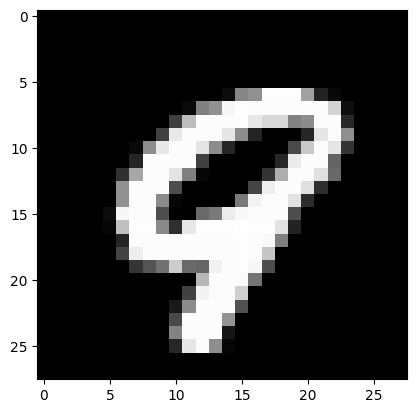

True label: 9, Predicted label: 9


In [ ]:
data_module = MNISTDataModule()
# MNIST 테스트 데이터셋 로드
predict_dataset = datasets.MNIST(
    root='./', train=False, download=True)

# 랜덤 이미지 선택
random_idx = torch.randint(len(predict_dataset), size=(1,)).item()
image, true_label = predict_dataset[random_idx]

# 이미지 확인 (optional)
transform = torchvision.transforms.ToTensor()
image_tensor = transform(image)
plt.imshow(image_tensor[0].squeeze(), cmap='gray')
plt.show()


# 모델 생성 및 학습된 가중치 로드
model_config = {}
model = ClassificationTask.load_from_checkpoint(
    "test_checkpoints/best_model.ckpt", model=CNNModel(config=model_config))

model.eval()
with torch.no_grad():
    x, y = data_module.predict_instantly([image], [true_label])
    loss, logits = model(x, y)

# Predict Data를 원하는 DataLoader로 직접 만들어서 predict를 수행하고자 할 경우
# data_module.predicted_dataloader_attr = your_dataloader
# trainer = pl.Trainer()
# loss, logits = trainer.predict(model, datamodule=data_module)


# 가장 높은 확률을 가진 클래스 예측
_, predicted_class = torch.max(logits, dim=1)

print(f'True label: {true_label}, Predicted label: {predicted_class.item()}')